# Audio processing project
### A pitch salience function derived from harmonic frequency deviations for polyphonic music analysis

[Article](https://www.researchgate.net/publication/265519905_A_Pitch_Salience_Function_Derived_from_Harmonic_Frequency_Deviations_for_Polyphonic_Music_Analysis)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd

import os
import json
import shutil
from datetime import datetime
import IPython

In [37]:
TAU = 2048
N = 4096
H = 8

DATA_PATH = "/mnt/PEZ/piano_data/maps/"
FIGURES_PATH = "figures"


instruments_ids = ["AkPnBcht","AkPnBsdf","AkPnCGdD","AkPnStgb","ENSTDkAm","ENSTDkCl","SptkBGAm","SptkBGCl","StbgTGd2"]
ISOL_types = ["CH","NO","RE","ST","TR1","TR2"]


In [27]:
def make_spectrogram(signal, N, tau, samplerate, hanning = True, N_target_pad = None):
    """ Computes spectrogram on windows of size N, shifted of tau samples. Applies zero-padding and/or hanning window is required

    Parameters
    ----------
    signal : ndarray
        1D signal to compute the spectrogram of
    N : int
        size of the windows FFT is applied on
    tau : int
        window shift size
    samplerate : int
    hanning : bool, optional
        apply hanning on window before fft, by default True
    N_target_pad : int, optional
        zero-pad target size, by default None

    Returns
    -------
    spectrogram, frequencies

    """
    if N_target_pad == None:
        N_target_pad = N

    spectrogram = []
    for i in range(len(signal)//tau -1):
        if hanning:
            spectrum = np.fft.fft(signal[i*tau: i*tau + N]*np.hanning(N), N_target_pad)
        else:
            spectrum = np.fft.fft(signal[i*tau: i*tau + N], N_target_pad)

        spectrogram.append(abs(spectrum)[:N_target_pad//2])

    frequencies =  np.arange(N_target_pad//2)*(samplerate/N_target_pad)
    return np.array(spectrogram), frequencies

In [128]:
def p_maxima_indices(signal, p = None):
    """ Return `p` largest local maxima of `signal`"""
    maxima_indices =  np.where(np.diff(np.sign(np.diff(signal))) < 0)[0] +1
    return maxima_indices[np.argsort(- signal[maxima_indices])][:p]

In [129]:
def interpolate_maximas(maxima_indices, spectrum, frequencies):
    """
    Interpolate the maxima given by `maxima_indices` with 2-degree polynom using previous and next value in `spectrum`
    Returns interpolated frequencies and amplitudes arrays
    """
    Ms = [[m-1, m, m+1] for m in maxima_indices]
    coeff_interp = np.array([np.polyfit(frequencies[M], spectrum[M], deg=2) for M in Ms])

    if len(coeff_interp) == 0: 
        return None, None
        
    interp_frequencies = -coeff_interp[:,1]/(2*coeff_interp[:,0])
    f = np.array([interp_frequencies**2, interp_frequencies, np.ones(len(interp_frequencies))]).T

    interp_spectrum = np.sum(coeff_interp*f, axis = 1)
    return interp_frequencies, interp_spectrum


In [30]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def G(f_p_prime, f_p, h, beta = 0.):
    """ Compute G funtion (gaussian function centered in hth corrected harmonic of `f_p` with parameter `beta`, in the peak frequency `f_p_prime`

    Parameters
    ----------
    f_p_prime : float
        Tested peak frequency
    f_p : _type_
        pitch candidate
    h : _type_
        harmonic number test
    beta : float, optional
        inharmonicity coeff, by default 0

    """
    alpha = 20.
    mu = h*f_p*np.sqrt(1+beta*h**2)
    sigma = mu*(1 -2**(alpha/1200))

    return gaussian(f_p_prime, mu, sigma)


In [31]:
def deviation(f):
    """ Computes the deviation of `f` to the equal tempered scale """
    f_ref = 440
    note = 12*np.log2(f/f_ref)
    return 100*(note - np.round(note))

In [130]:
def deviation_weighted(f_p, peak_f, h):
    """ Sum of weighted deviations of `peak_f` frequencies to harmonic number h of `f_p`"""
    return np.sum(G(peak_f, f_p, h)*deviation(peak_f))

In [131]:
def get_midi_indx(f_p):
    """ Return float midi index of `f_p`"""
    f_ref = 440
    return 69 + 12*np.log2(f_p/f_ref)

In [132]:
def compute_saliencies(peak_f, peak_powers):
    """ Compute saliencies of peak frequencies `peak_f` with amplitudes `peak_powers`"""
    S = []
    for i in range(len(peak_f)):
        # get candidate frequency and associated power
        f_p = peak_f[i]
        power_p = peak_powers[i]

        d_p_hat =np.array([deviation_weighted(f_p, peak_f, h) for h in range(1, H + 1)])
        d_p = np.array([deviation(f_p*h) for h in range(1, H + 1 )])
        S.append(power_p*(d_p_hat @ d_p))
    return np.array(S)

In [35]:
# For the MAPS dataset

def load_ISOL_folder_ids(data_path, instrument_id, type):
    """ Laod all base name of ISOL sound with given intrument, and type"""
    path = os.path.join(data_path, instrument_id, "ISOL", type)
    files = os.listdir(path)
    uids = np.unique([fname.rpartition(".")[0] for fname in files])
    return path, uids

def load_MUS_folder_ids(data_path, instrument_id):
    """ Laod all base name of MUS sound with given intrument"""
    path = os.path.join(data_path, instrument_id, "MUS")
    files = os.listdir(path)
    uids = np.unique([fname.rpartition(".")[0] for fname in files])
    return path, uids



In [133]:
def load_sound_and_annotation(path):
    """ Return grid of notesn samplerate, and signal of a MAPS soundfile located at `path` (path without extension .wav)"""
    annotation = pd.read_csv( path + ".txt", sep="\t").to_numpy()
    
    samplerate, signal = wavfile.read(path + ".wav")
    assert signal.ndim == 2
    signal = signal[:,0]
    signal = signal[:-(len(signal)%TAU)]

    grid = np.zeros((128, len(signal)//TAU)).astype(bool)
    annotation[:, [0,1]] = ((annotation[:,[0,1]]*samplerate)//TAU)

    for note in annotation.astype(int):
        grid[note[2], note[0]:note[1]+1] = True

    return grid, samplerate, signal

    

In [134]:

def pitch_estimation(signal,samplerate, N_pad = N, T = 0.2):
    """ Computes piano roll estimation of signal (uses global variables as parameters)

    Parameters
    ----------
    signal : ndarray
        signal
    samplerate : int
        signal samplerate
        N_pad : int, optional
        target zero-pad size if any, by default N
    T : float, optional
        salience threshold, by default 0.2

    Returns
    -------
    ndarray(bool)
        Boolean piano roll as a 2D array (128, number of windows)
    """
    spectrogram, frequencies = make_spectrogram(signal, N, TAU, samplerate, hanning=True, N_target_pad=N_pad) 

    grid_predict = np.zeros((128, len(signal)//TAU)).astype(bool)
    # for spectrum in spectrogram[10:15]:
    for i,spectrum in enumerate(spectrogram):
        
        maximas = p_maxima_indices(spectrum, 20)
        peak_f, peak_powers = interpolate_maximas(maximas, spectrum, frequencies)
        if peak_f is not None:
            S = compute_saliencies(peak_f, peak_powers)
            S = S/np.max(S)
            selection = S > T
            
            S_final= S[selection]
            notes_final = S[selection]
            frequencies_final = peak_f[selection]
            notes_final = np.round(get_midi_indx(frequencies_final)).astype(int)
            notes_final = notes_final[(notes_final <= 127) & (notes_final >= 0)]

            grid_predict[notes_final,i] = True

    return grid_predict

In [39]:
def compute_scores(true_grid, predict_grid):
    """" Computes Precision, Recall, F-score between two boolean grids"""
    
    equal = (true_grid == predict_grid)

    TP = (equal * true_grid).sum()
    FP = predict_grid.sum() - TP
    FN = ((~predict_grid)*true_grid).sum()

    if TP == 0:
        return 0.,0., 0.

    P = TP/(TP + FP)
    R = TP/(TP + FN)
    F = 2*P*R/(P + R)

    return P, R, F

In [40]:
def save_score(file, exp_dict, scores):
    """ Append scores of given experiment in JSON file"""

    # copy old result file for safety
    shutil.copyfile(file, file + ".copy_" + str(datetime.now()) )

    results = json.load(open(file, "r"))
    print(results)
    scores_d = {
        "P": scores[0],
        "R": scores[1],
        "F": scores[2]
    }

    d = {**exp_dict, "scores": scores_d}

    results.append(d)
    print(results)
    json.dump(results, open(file, "w+"))

In [43]:
def median_filt_grid(grid):
    kernel = np.array([1,1,1,1,1])
    grid_medianed = np.array([ np.convolve(notes, kernel, mode= 'same') for notes in grid])
    grid_medianed[grid_medianed<= 2] = 0
    grid_medianed[grid_medianed >= 3] = 1
    grid_medianed = grid_medianed.astype(bool)
    return grid_medianed

In [90]:
def plot_grids(true, predict, figsize = (10,20)):
    plt.figure(figsize=figsize)
    
    
    z = np.zeros(true.shape)
    o = np.ones(true.shape)

    img_red = (np.dstack((o, z, z)) * 255.999)
    img_green = (np.dstack((z, o, z)) * 255.999)
    img_blue = (np.dstack((z, z, o)) * 255.999)

    equal = (predict == true)

    TP = (equal * true)
    FP = predict ^ TP
    FN = ((~predict)*true)

    # plt.imshow(img_blue*grid[:, :, np.newaxis])
    plt.imshow(np.ones(true.shape + (3,))*(~(true | predict))[:,:,np.newaxis] + img_green*TP[:,:,np.newaxis] + img_red*FP[:,:,np.newaxis] + img_blue*FN[:,:,np.newaxis])
    return

# Vizualisation

In [374]:
# path_viz1 = "AkPnBcht/ISOL/NO/MAPS_ISOL_NO_F_S0_M23_AkPnBcht"
path_viz1 = "AkPnBcht/ISOL/NO/MAPS_ISOL_NO_F_S1_M54_AkPnBcht"

grid, samplerate, signal = load_sound_and_annotation(os.path.join(DATA_PATH, path_viz1))
signal = signal/np.max(np.abs(signal))

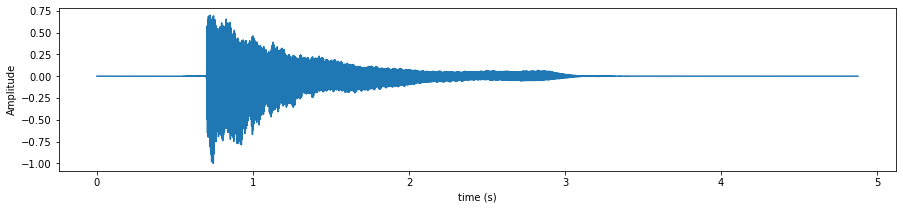

In [317]:
plt.figure(figsize=(15, 3))
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.plot(np.arange(0, len(signal))/samplerate, signal)
plt.savefig(fname= FIGURES_PATH + '/raw_signal.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


In [318]:
signal_window = signal[int(0.8*samplerate): int(0.8*samplerate) + N]


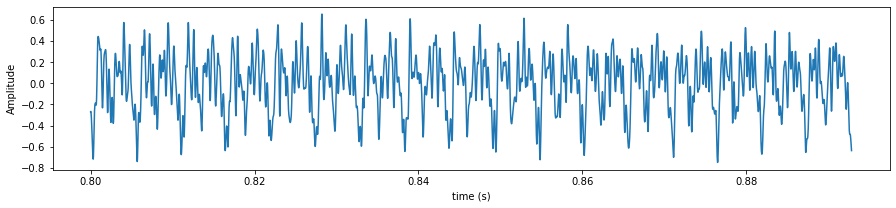

In [319]:
plt.figure(figsize=(15, 3))
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.plot(np.arange(int(0.8*samplerate), int(0.8*samplerate) + N)/samplerate, signal_window)
plt.savefig(fname= FIGURES_PATH + '/raw_signal_window.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


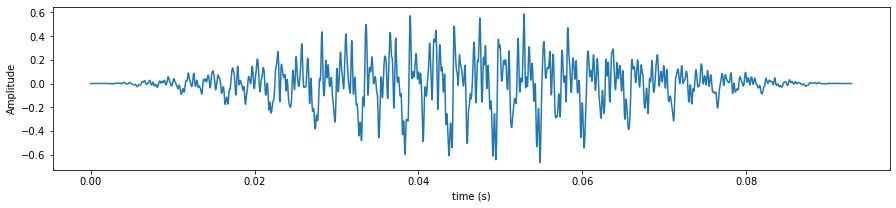

In [320]:
plt.figure(figsize=(15, 3))
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.plot(np.arange(0, len(signal_window))/samplerate, signal_window*np.hanning(N))
plt.savefig(fname= FIGURES_PATH + '/raw_signal_window_hanning.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


Spectrogram without and with zero padding

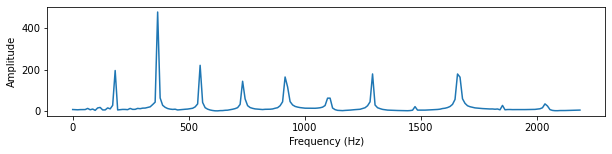

In [322]:
spectrum = np.fft.fft(signal_window, N)
spectrum = np.abs(spectrum[: N//2])
frequencies = np.arange(N//2)*samplerate/N

plt.figure(figsize=(10,2))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(frequencies[:len(frequencies)//10], spectrum[:len(frequencies)//10])
plt.savefig(fname=f'figures/spectrum_amplitudes.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


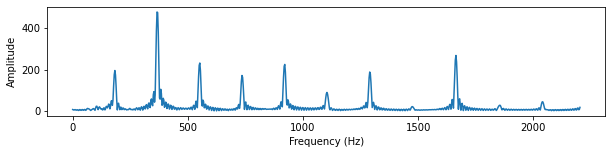

In [323]:
signal_window = signal[int(0.8*samplerate): int(0.8*samplerate) + N]

N_extend = 4*N

spectrum = np.fft.fft(signal_window, N_extend)
spectrum = np.abs(spectrum[: N_extend//2])
frequencies = np.arange(N_extend//2)*samplerate/(N_extend)
plt.figure(figsize=(10,2))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(frequencies[:len(frequencies)//10], spectrum[:len(frequencies)//10])
plt.savefig(fname=f'figures/spectrum_amplitudes_4N.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


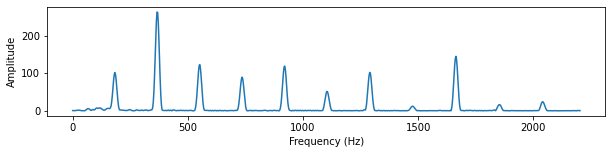

In [324]:
signal_window = signal[int(0.8*samplerate): int(0.8*samplerate) + N]

N_extend = 4*N

spectrum = np.fft.fft(signal_window*np.hamming(N), N_extend)
spectrum = np.abs(spectrum[: N_extend//2])
frequencies = np.arange(N_extend//2)*samplerate/(N_extend)
plt.figure(figsize=(10,2))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(frequencies[:len(frequencies)//10], spectrum[:len(frequencies)//10])

plt.savefig(fname=f'figures/spectrum_amplitudes_4N_hamming.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

[ 367.24981269 1663.15109149  550.95859887  919.55884821 1290.00235006
  183.13988967 2807.66739873  735.29367957 2229.55383007 1103.9945558
 2420.6249618  2039.84987333 3800.38603088 3199.5292122  3002.56838371
 1852.43073985 4417.29215091 1475.13440616 3396.75440836 3598.61887746]
[ 366.06445312 1663.43994141  551.78833008  920.54443359 1289.30053711
  183.03222656 2807.39135742  734.82055664 2228.68652344 1103.57666016
 2419.79370117 2040.27099609 3800.61035156 3200.37231445 3003.88183594
 1851.85546875 4416.99829102 1475.02441406 3396.86279297 3598.73657227]


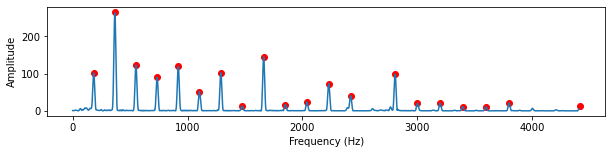

In [338]:
maximas = p_maxima_indices(spectrum, 20)
peak_f, peak_powers = interpolate_maximas(maximas, spectrum, frequencies)

plt.figure(figsize=(10,2))
# plt.figure(figsize=(30,15))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(frequencies[:len(frequencies)//5], spectrum[:len(frequencies)//5])
plt.scatter(peak_f, peak_powers, color = 'red')
# plt.scatter(frequencies[maximas], spectrum[maximas], color = 'green')
plt.savefig(fname=f'figures/spectrum_amplitudes_4N_hamming_maxima.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


print(peak_f)
print(frequencies[maximas])

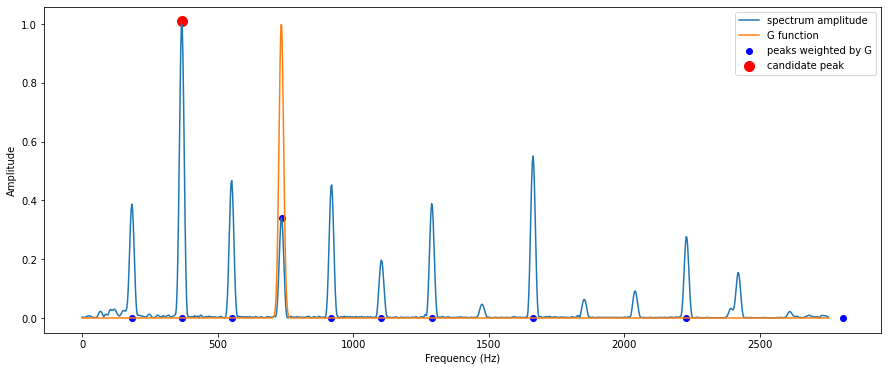

In [372]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(30,15))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

factor_display = 8

abs_g = frequencies//factor_display
g_values = G(abs_g, peak_f[0], 2)

g_values_peaks = G(peak_f, peak_f[0], 2)

plt.plot(frequencies[:len(frequencies)//factor_display], spectrum[:len(frequencies)//factor_display]/np.max(spectrum), label = "spectrum amplitude")
plt.plot(abs_g, g_values, label = "G function")
plt.scatter(peak_f[:10], ((peak_powers/np.max(spectrum))*g_values_peaks)[:10], color = 'blue', label = "peaks weighted by G")
plt.scatter(peak_f[0], peak_powers[0]/np.max(spectrum), color = "red", s = 100, label = "candidate peak")
plt.legend()
plt.savefig(fname=f'figures/peaks_G.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)


In [373]:
peak_f[0]

367.2498126944898

# Apply method

In [ ]:
# path, uids = load_ISOL_folder_ids(DATA_PATH, instruments_ids[0], ISOL_types[2])

# exp = {
#     "instruments":  ["AkPnBcht"],
#     "set_type": "MUS"
# }

# Experiment parameters
exp = {
    "instruments": instruments_ids,
    "set_type": "ISOL",
    "N_pad": 4*N,
    "exp_type": "4N_pad",
    "isol_type" : "NO"
}


# Run through experiment modalities
for instrument in exp["instruments"]:
    exp_dict = { k: exp[k] for k in ["set_type", "N_pad", "exp_type", "isol_type"] }
    exp_dict["instrument"]= instrument

    set_type = exp["set_type"]
    if  set_type == "ISOL":
        isol_type = exp["isol_type"]
        path, uids = load_ISOL_folder_ids(DATA_PATH, instrument, isol_type)
    elif set_type == "MUS":
        path, uids = load_MUS_folder_ids(DATA_PATH, instrument)

    scores = []

    for uid in uids[:]:

        # Load sound and annotation
        path_test_1 = os.path.join(path, uid)
        grid, samplerate, signal = load_sound_and_annotation(path_test_1)
        
        # Prediction
        grid_predict = pitch_estimation(signal, samplerate, N_pad=exp["N_pad"])
        kernel = np.array([1,1,1,1,1])
        convolved = np.convolve(grid_predict[100], kernel, mode= 'same')
        
        # MEdian filter
        grid_medianed = np.array([ np.convolve(notes, kernel, mode= 'same') for notes in grid_predict])
        grid_medianed[grid_medianed<= 2] = 0
        grid_medianed[grid_medianed >= 3] = 1
        grid_medianed = grid_medianed.astype(bool)
        
        scores.append(compute_scores(grid, grid_medianed))
        print(path_test_1, scores[-1])


    # Average score for instrument and save results
    scores_mean_save = np.array(scores).mean(axis = 0)
    save_score("results_TEMP.json", exp_dict, scores_mean_save)
    # save_score("results.json", instrument, set_type, "base", scores_mean_save)

    

In [ ]:
# path_example = DATA_PATH + "/AkPnBcht/ISOL/NO/MAPS_ISOL_NO_F_S1_M54_AkPnBcht"
# path_example = DATA_PATH + "/AkPnBcht/MUS/MAPS_MUS-chpn-p1_AkPnBcht"
# folder = "mus_example"

path_example = DATA_PATH + "/AkPnBsdf/ISOL/NO/MAPS_ISOL_NO_F_S0_M69_AkPnBsdf"
folder = "isol_example"

figsize= (10,20)
range_display_grid = range(40,128)

grid, samplerate, signal = load_sound_and_annotation(path_example)


T_list = np.linspace(.1, .9, 9)
scores = []
for T in T_list:
    grid_predict = pitch_estimation(signal, samplerate, N_pad=N*4, T=T)
    grid_medianed = median_filt_grid(grid_predict)
    plot_grids(grid[range_display_grid], grid_medianed[range_display_grid], figsize = figsize)
    plt.savefig(fname='figures/{}/result_mus_{}.pdf'.format(folder, str(T)), dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
    scores.append(compute_scores(grid, grid_predict))

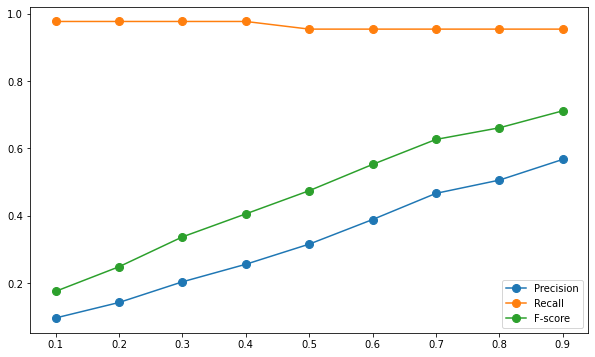

In [93]:
p, r, f = zip(*scores)
plt.figure(figsize = (10,6))
plt.plot(T_list, p, marker = 'o', label = "Precision", markersize = 8)
plt.plot(T_list, r, marker = 'o', label = 'Recall', markersize = 8)
plt.plot(T_list, f, marker = 'o', label = "F-score", markersize = 8)
plt.legend()
plt.savefig(fname='figures/{}/scores_T.pdf'.format(folder), dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

# Scores

In [220]:
json_normal_no_isol = json.load(open("results_normal_isol_no.json", "r"))
json_zero_pad_no_isol = json.load(open("results_zero_pad_isol_no.json", "r"))

In [228]:
score_normal = np.mean([x["scores"]["F"] for x in json_normal_no_isol])
score_zero_pad = np.mean([x["scores"]["F"] for x in json_zero_pad_no_isol])

In [231]:
print(score_normal, score_zero_pad)

0.36140876252406823 0.36946882999906316


# Deviations



Generate some random frequencies and compute the closest notes in the scale, and the deviation to it

In [257]:
map_midi = {127 :"G9",126 :"F#9/Gb9",125 :"F9",124 :"E9",123 :"D#9/Eb9",122 :"D9",121 :"C#9/Db9",120 :"C9",119 :"B8",118 :"A#8/Bb8",117 :"A8",116 :"G#8/Ab8",115 :"G8",114 :"F#8/Gb8",113 :"F8",112 :"E8",111 :"D#8/Eb8",110 :"D8",109 :"C#8/Db8",108 :"C8",107 :"B7",106 :"A#7/Bb7",105 :"A7",104 :"G#7/Ab7",103 :"G7",102 :"F#7/Gb7",101 :"F7",100 :"E7",99 :"D#7/Eb7",98 :"D7",97 :"C#7/Db7",96 :"C7",95 :"B6",94 :"A#6/Bb6",93 :"A6",92 :"G#6/Ab6",91 :"G6",90 :"F#6/Gb6",89 :"F6",88 :"E6",87 :"D#6/Eb6",86 :"D6",85 :"C#6/Db6",84 :"C6",83 :"B5",82 :"A#5/Bb5",81 :"A5",80 :"G#5/Ab5",79 :"G5",78 :"F#5/Gb5",77 :"F5",76 :"E5",75 :"D#5/Eb5",74 :"D5",73 :"C#5/Db5",72 :"C5",71 :"B4",70 :"A#4/Bb4",69 :"A4",68 :"G#4/Ab4",67 :"G4",66 :"F#4/Gb4",65 :"F4",64 :"E4",63 :"D#4/Eb4",62 :"D4",61 :"C#4/Db4",60 :"C4 ",59 :"B3",58 :"A#3/Bb3",57 :"A3",56 :"G#3/Ab3",55 :"G3",54 :"F#3/Gb3",53 :"F3",52 :"E3",51 :"D#3/Eb3",50 :"D3",49 :"C#3/Db3",48 :"C3",47 :"B2",46 :"A#2/Bb2",45 :"A2",44 :"G#2/Ab2",43 :"G2",42 :"F#2/Gb2",41 :"F2",40 :"E2",39 :"D#2/Eb2",38 :"D2",37 :"C#2/Db2",36 :"C2",35 :"B1",34 :"A#1/Bb1",33 :"A1",32 :"G#1/Ab1",31 :"G1",30 :"F#1/Gb1",29 :"F1",28 :"E1",27 :"D#1/Eb1",26 :"D1",25 :"C#1/Db1",24 :"C1",23 :"B0",22 :"A#0/Bb0",21 :"A0",20 :"G#",19 :"G",18 :"F#",17 :"F",16 :"E",15 :"D#",14 :"D",13 :"C#",12 :"C0",11 :"B",10 :"A#",9 :"A",8 :"G#",7 :"G",6 :"F#",5 :"F",4 :"E",3 :"D#",2 :"D",1 :"C#",0 :"C-1"}

f_list = 30 + np.random.random(5)*2000.
deviations = deviation(f_list)
midis = (np.round(12*np.log2(f_list/440)) + 69).astype(int)

for i,f in enumerate(f_list):
    print(np.round(f, 2),"&", map_midi[midis[i]], "&", np.round(deviations[i],2))

1606.27 & G6 & 41.77
1387.65 & F6 & -11.52
718.31 & F5 & 48.52
439.37 & A4 & -2.48
1949.99 & B6 & -22.53


# Other


In [119]:
map_instrument_maps = {"StbgTGd2": "Hybrid",
"AkPnBsdf": "Boesendorfer 290 Imperial (church)",
"AkPnBcht": "Bechstein D 280 (concert hall)",
"AkPnCGdD": "Concert Grand D (studio)",
"AkPnStgb": "Steingraeber 130 (jazz club)",
"SptkBGAm": "Steinway D (ambient)",
"SptkBGCl": "Steinway D (close)",
"ENSTDkAm": "Yamaha Disklavier MIII (ambient)",
"ENSTDkCl": "Yamaha Disklavier MIII (close)"}


In [127]:
json_scores = json.load(open("results_zero_pad_isol_no.json"))
for s in json_scores:
    print(map_instrument_maps[s["instrument"]], "&", " & ".join([str(round(x,2)) for x in s["scores"].values()]), "\\\\" )

Bechstein D 280 (concert hall) & 0.27 & 0.65 & 0.36 \\
Boesendorfer 290 Imperial (church) & 0.26 & 0.67 & 0.36 \\
Concert Grand D (studio) & 0.21 & 0.68 & 0.3 \\
Steingraeber 130 (jazz club) & 0.27 & 0.61 & 0.36 \\
Yamaha Disklavier MIII (ambient) & 0.22 & 0.5 & 0.29 \\
Yamaha Disklavier MIII (close) & 0.25 & 0.52 & 0.32 \\
Steinway D (ambient) & 0.34 & 0.74 & 0.44 \\
Steinway D (close) & 0.42 & 0.76 & 0.51 \\
Hybrid & 0.29 & 0.59 & 0.38 \\
